In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# setting things up:

In [3]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
output_path = path / "Output"
paths = forcing_path, output_path, observations_path
figure_path = path / "Figures"

In [4]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

In [5]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qm) - np.log(Qo))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [6]:
def plot_hydrograph(ds_combined, ax):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat="mean").plot(ax=ax, color="C1",lw=0.5,label=f"mean NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Run ensemble of {n_particles} particles");
    return ax

In [7]:
def plot_variable(ds_combined, variable, axs):    
    axs[0] = plot_hydrograph(ds_combined, axs[0])
    n_particles = ds_combined.attrs['n_particles']
    
    for i, var in enumerate(variable):
        for j in range(n_particles):
            axs[i+1].fill_between(ds_combined.time, 
                             ds_combined[var].sel(summary_stat="min").values,
                             ds_combined[var].sel(summary_stat="max").values, color=f"C{i}",alpha=0.5)
            axs[i+1].set_title(var_names[var])
            axs[i+1].set_ylabel(f'{var} [{units[var]}]')
    return axs

# Loading files

In [8]:
# files_1 = list(output_path.glob('*_pp-*_sigma_ps-*_w-*_N-*_*04-30 2*.nc')) + list(output_path.glob('*_pp-*_sigma_ps-*_w-*_N-*_*05-01*.nc'))

In [9]:
HRU_ids = [path.name[0:8] for path in
           forcing_path.glob("*_lump_cida_forcing_leap.txt")]

In [12]:
files = list((output_path / 'more_catchments_3y').glob('*.nc'))
# files =  list((output_path / 'run_10_y').glob('*.nc'))
# files =  list((output_path / 'low_n').glob('*.nc'))
# files =  list((output_path / 'iterate_hyperparams').glob('*.nc'))
files

[PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/nbs_33_run_diff_sig_s/Output/more_catchments_3y/01134500_pp-0.003_sigma_ps-2_w-0.45_N-200_2024-05-01 10_12.nc'),
 PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/nbs_33_run_diff_sig_s/Output/more_catchments_3y/01142500_pp-0.003_sigma_ps-2_w-0.45_N-200_2024-04-30 23_46.nc'),
 PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/nbs_33_run_diff_sig_s/Output/more_catchments_3y/01123000_pp-0.003_sigma_ps-2_w-0.45_N-200_2024-05-02 11_37.nc'),
 PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/nbs_33_run_diff_sig_s/Output/more_catchments_3y/01169000_pp-0.003_sigma_ps-2_w-0.45_N-200_2024-05-01 16_45.nc'),
 PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/nbs_33_run_diff_sig_s/Output/more_catchments_3y/01144000_pp-0.003_sigma_ps-2_w-0.45_N-200_2024-05-01 17_16.nc'),
 PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/nbs_33_run_diff_sig_s/Output/more_catchments_3y/01139000_pp-0.003_sigma_ps-2_w-0.45_N-200_2024-05-02 15_23.nc'),
 PosixPath

In [17]:
len(set([file.name.split("_")[0] for file in files]).intersection(set(HRU_ids)))

25

In [18]:
lst_ds = []
for file in files:
    ds = xr.open_dataset(file)
    lst_ds.append(ds)

In [19]:
i = 3
ds_combined = lst_ds[i]
ds_combined

<xarray.Dataset>
Dimensions:       (summary_stat: 3, time: 1127)
Coordinates:
  * summary_stat  (summary_stat) <U4 'min' 'max' 'mean'
  * time          (time) datetime64[ns] 1997-08-01 1997-08-02 ... 2000-08-31
Data variables: (12/16)
    Imax          (summary_stat, time) float64 ...
    Ce            (summary_stat, time) float64 ...
    Sumax         (summary_stat, time) float64 ...
    Beta          (summary_stat, time) float64 ...
    Pmax          (summary_stat, time) float64 ...
    Tlag          (summary_stat, time) float64 ...
    ...            ...
    Su            (summary_stat, time) float64 ...
    Sf            (summary_stat, time) float64 ...
    Ss            (summary_stat, time) float64 ...
    Sp            (summary_stat, time) float64 ...
    Q             (summary_stat, time) float64 ...
    Q_obs         (time) float64 ...
Attributes:
    title:              HBV storage & parameter terms data over time for 200 ...
    history:            Storage term results from ewatercycle_HBV.model
    sigma_pp:           0.003
    sigma_ps:           2
    sigma_w:            0.45
    assimilate_window:  3
    n_particles:        200
    HRU_id:             01169000

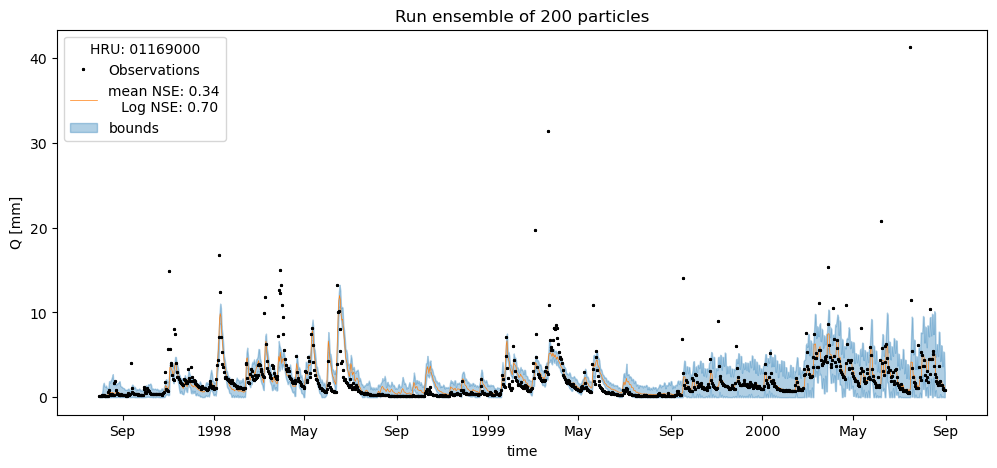

In [20]:
# for i, ds_combined in enumerate(lst_ds): 
#     fig, ax = plt.subplots(1,1,figsize=(12,5))
#     ax = plot_hydrograph(ds_combined, ax)
#     ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}");#bbox_to_anchor=(1.25,1))
#     fig.savefig(figure_path / (str(files[i].name[:-3]) + '_hydrograph.png'), bbox_inches="tight",dpi=400)
#     plt.close(fig)

fig, ax = plt.subplots(1,1,figsize=(12,5))
ax = plot_hydrograph(ds_combined, ax)
ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}");#bbox_to_anchor=(1.25,1))
fig.savefig(figure_path / (str(files[i].name[:-3]) + '_hydrograph.png'), bbox_inches="tight",dpi=400)


In [22]:
# fig, ax = plt.subplots(3,1, figsize=(12,5),sharex=True)
# ax[0] = plot_hydrograph(ds_combined, ax[0])
# ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.2,1))
# for j, val in enumerate(['n_resample','Neff']):
#     ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
#     ax[j+1].legend(bbox_to_anchor=(1.2,1))
#     ax[j+1].set_ylabel('Number of particles')
# ax[2].axhline(ds_combined.attrs['n_particles']*0.8, color='k');

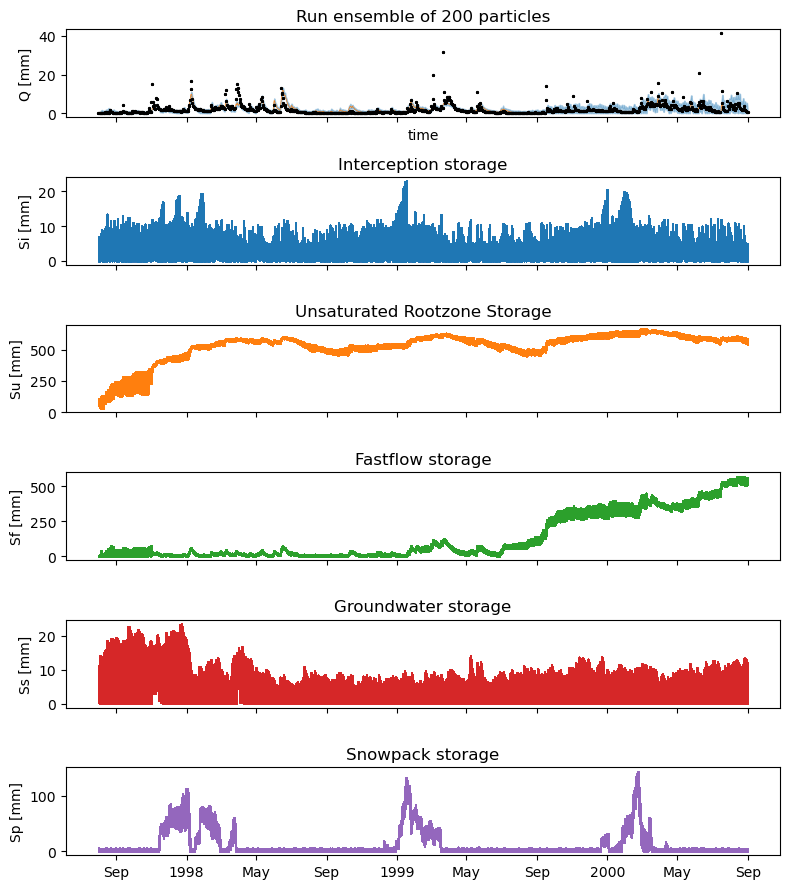

In [23]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
axs = plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

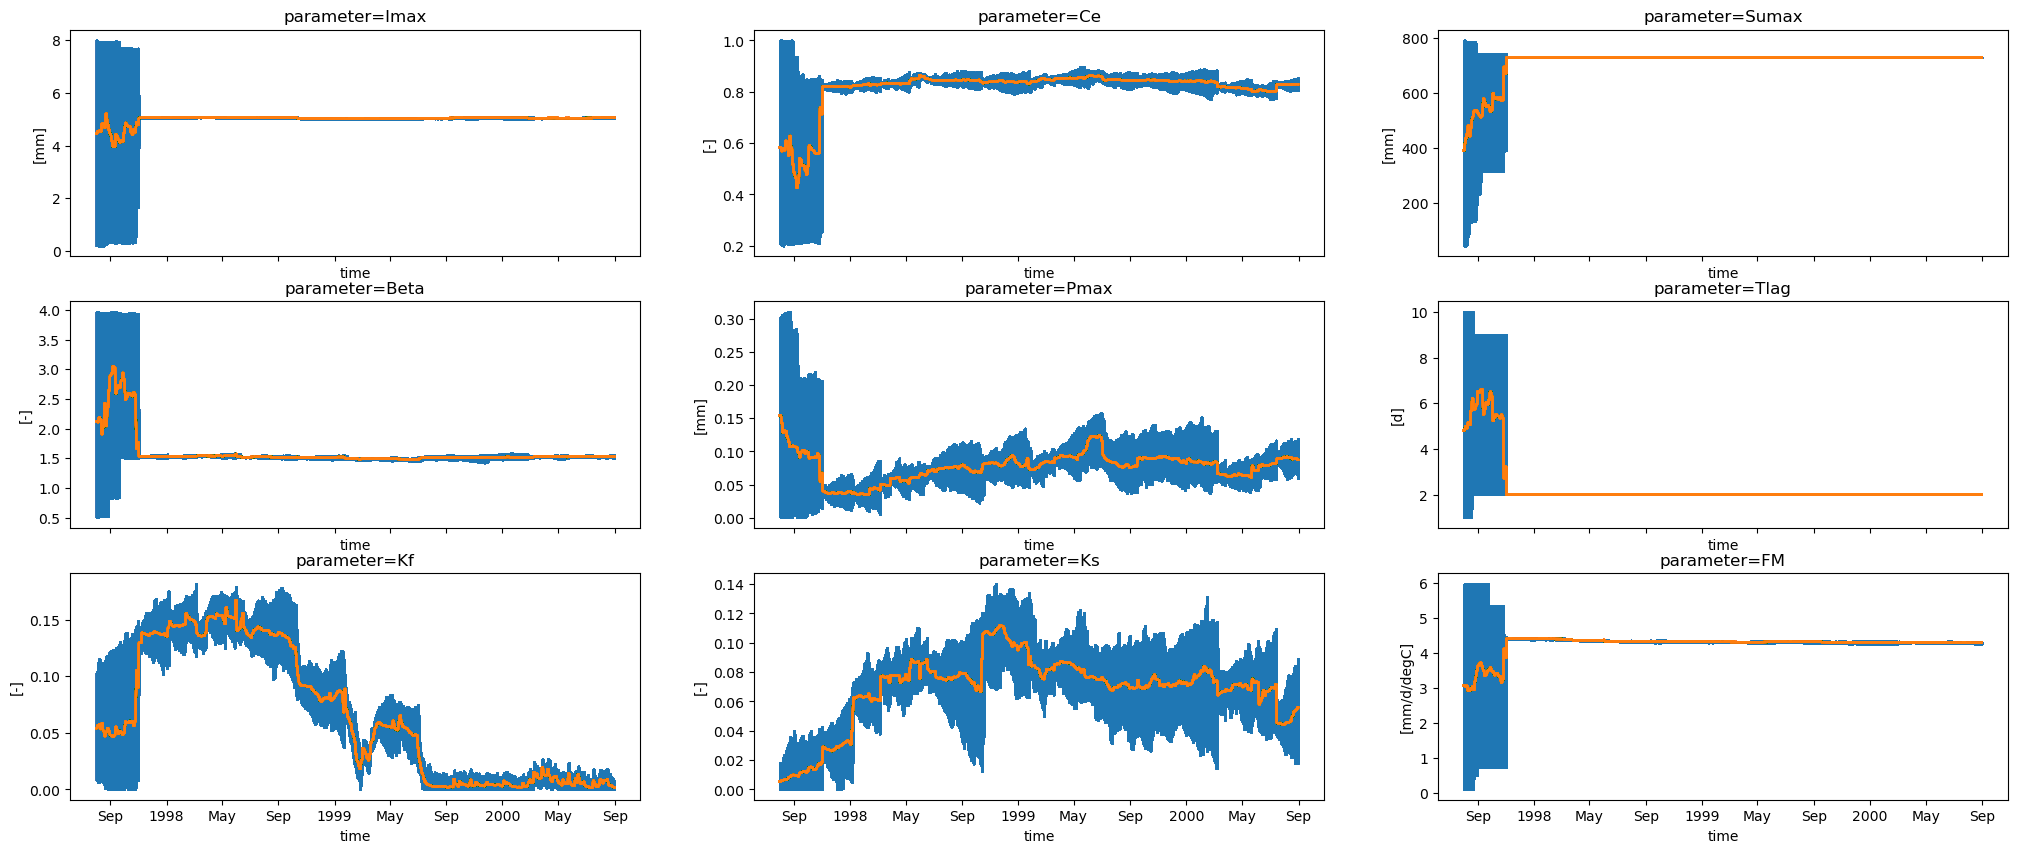

In [24]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [25]:
param_names_0 = param_names[:4]
param_names_1 = param_names[4:]

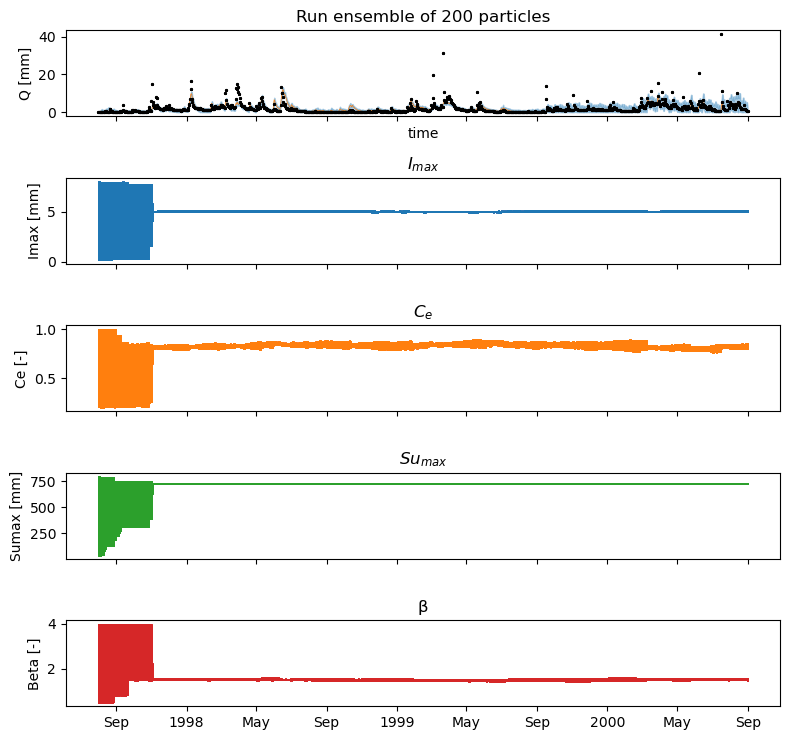

In [26]:
n =5
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
axs = plot_variable(ds_combined, param_names_0, axs)
fig.tight_layout()

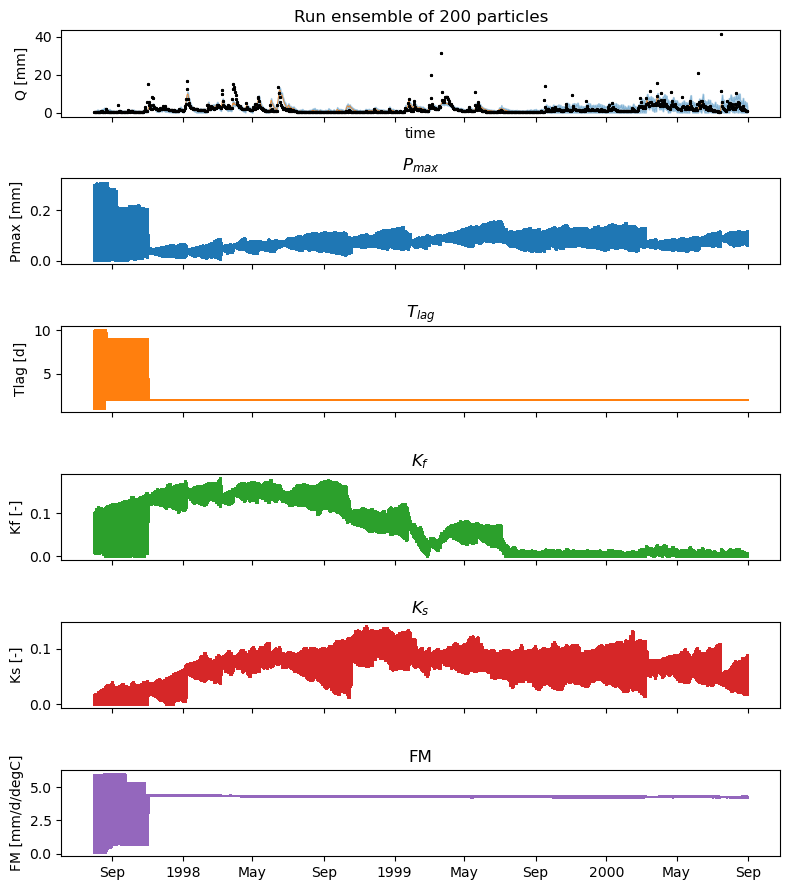

In [27]:
n = 6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
axs = plot_variable(ds_combined, param_names_1, axs)
fig.tight_layout()